# Example 03. Process a LEAF time-series

This example generates a Plant Area Volume Density (PAVD) profile time-series following Calders et al. (in review).

## Load all the required modules

In [20]:
import os
import glob
import numpy as np

import matplotlib.pyplot as plt

from pylidar_canopy import leaf_io, plant_profile, grid

## Some plotting functions

In [21]:
def plot_vertical_profiles(profiles, height, labels=['Hinge','Linear','Weighted'], title=None,
                          figsize=[6,6], ylim=(0,50), xlim=None, xlabel=r'PAVD ($m^2 m^{-3}$)'):
    """Example function to plot a vertical profile"""
    fig, ax = plt.subplots(figsize=figsize, squeeze=True)
    with plt.style.context('seaborn-talk'):
        for i,profile in enumerate(profiles):
            if labels is None:
                ax.plot(profile, height, linewidth=1.5)
            else:
                ax.plot(profile, height, label=labels[i], linewidth=1.5)
        ax.set(xlabel=xlabel, ylabel='Height (m)')
        ax.set(ylim=ylim, xlim=xlim, title=title)
        ax.set_facecolor('white')
        if labels is not None:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Zenith Angle')
    fig.tight_layout() 
    plt.show()


## Identify all of the input files

Create a list of all files available to generate a time-series.

In [25]:
os.chdir('/gpfs/data1/vclgp/data/leaf/01Nov22/361')

# Data files
hemi_csv_list = sorted( glob.glob('data/ESS00361_?*_hemi_*.csv') )
hinge_csv_list = sorted( glob.glob('data/ESS00361_?*_hinge_*.csv') )
ground_csv_list = sorted( glob.glob('data/ESS00361_?*_ground_*.csv') )

# Power files
power_csv_list = sorted( glob.glob('pwr/ESS00361_pwr_*.csv') )

In [26]:
hemi_csv_list

['data/ESS00361_0134_hemi_20220524-020028Z_0200_0100.csv',
 'data/ESS00361_0139_hemi_20221015-020027Z_0200_0100.csv',
 'data/ESS00361_0144_hemi_20221016-020028Z_0200_0100.csv',
 'data/ESS00361_0149_hemi_20221017-020028Z_0200_0100.csv',
 'data/ESS00361_0154_hemi_20221018-020028Z_0200_0100.csv',
 'data/ESS00361_0159_hemi_20221019-020028Z_0200_0100.csv',
 'data/ESS00361_0164_hemi_20221020-020028Z_0200_0100.csv',
 'data/ESS00361_0169_hemi_20221020-080028Z_0800_0400.csv',
 'data/ESS00361_0170_hemi_20221021-020031Z_0200_0100.csv',
 'data/ESS00361_0173_hemi_20221021-040028Z_0400_0200.csv',
 'data/ESS00361_0176_hemi_20221022-020028Z_0200_0100.csv',
 'data/ESS00361_0181_hemi_20221023-020028Z_0200_0100.csv',
 'data/ESS00361_0186_hemi_20221024-020028Z_0200_0100.csv',
 'data/ESS00361_0191_hemi_20221025-020028Z_0200_0100.csv',
 'data/ESS00361_0196_hemi_20221026-020028Z_0200_0100.csv',
 'data/ESS00361_0199_hemi_20221026-040028Z_0400_0200.csv',
 'data/ESS00361_0202_hemi_20221027-020028Z_0200_0100.csv

## Generate the $P_{gap}$ profiles

Plot the $P_{gap}$ profiles for all the scans. Note that no quality filtering has taken place yet.

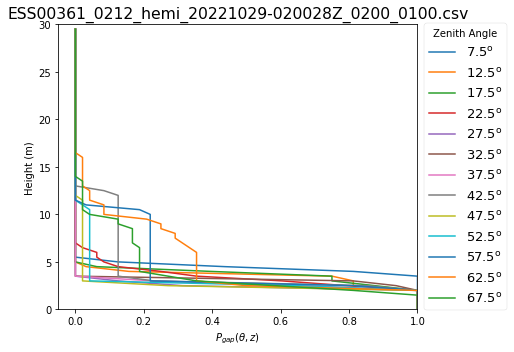

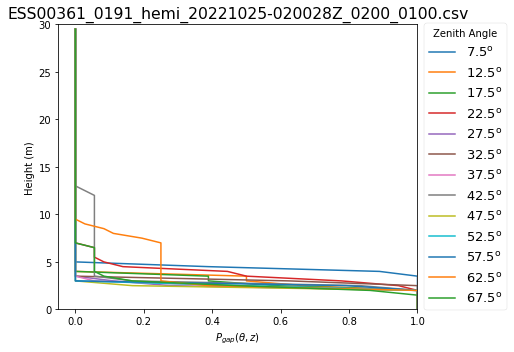

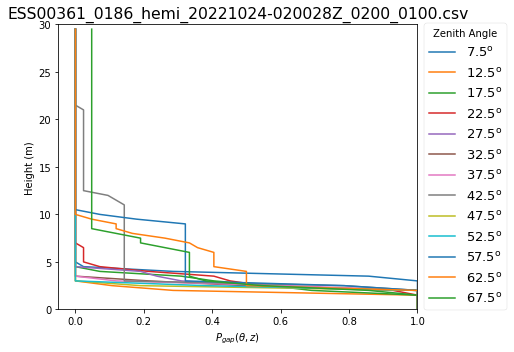

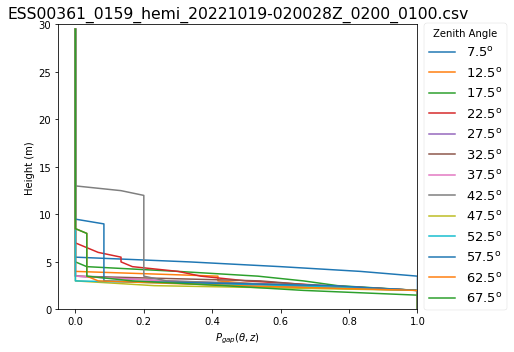

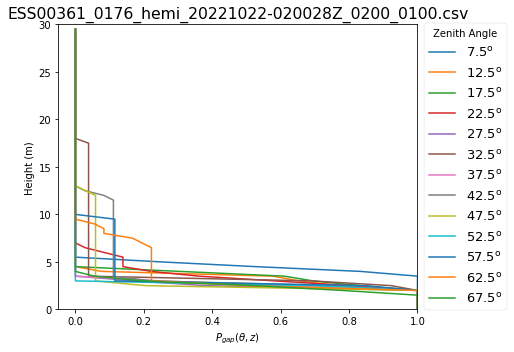

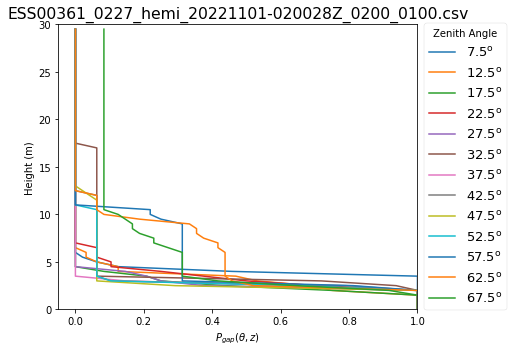

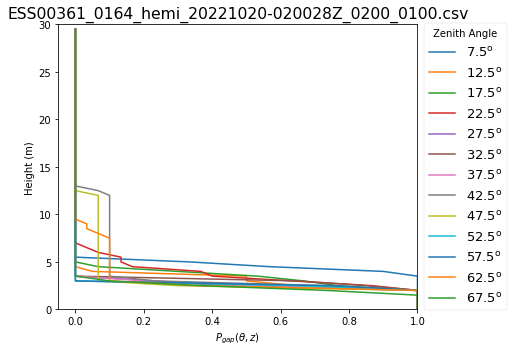

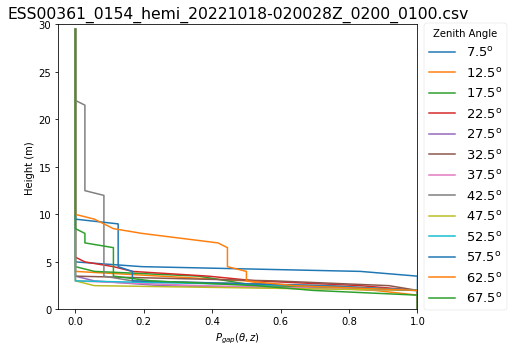

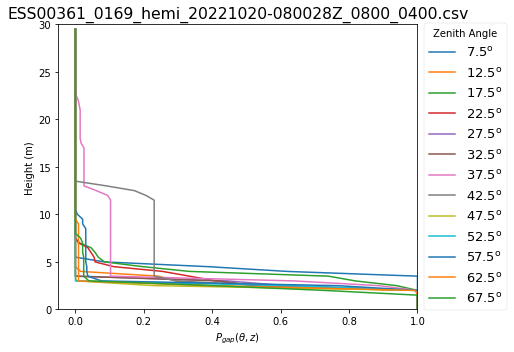

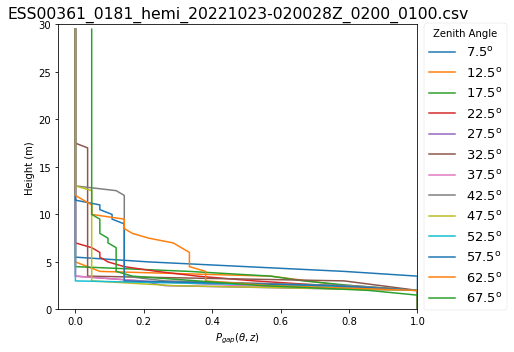

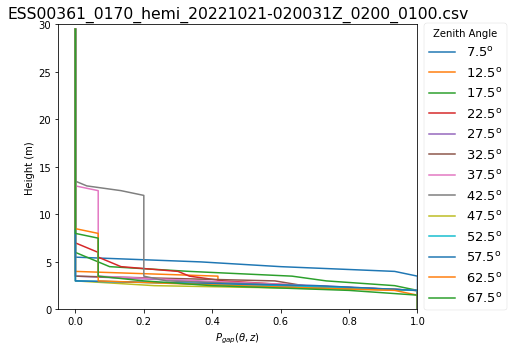

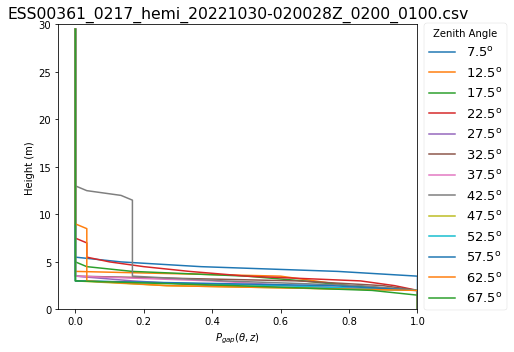

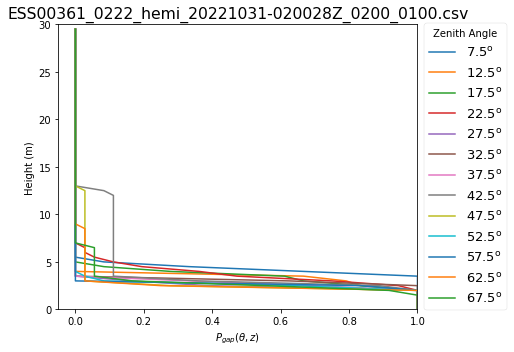

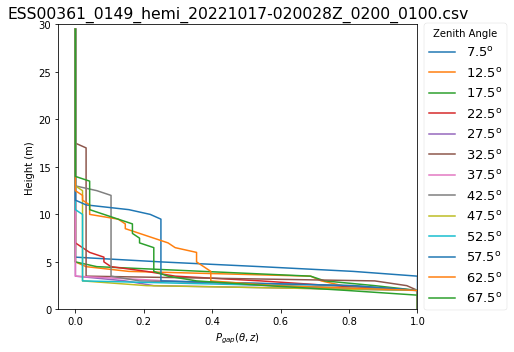

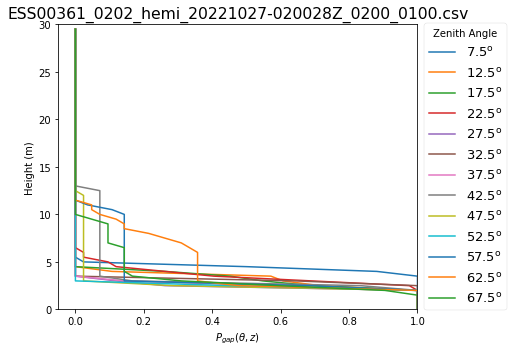

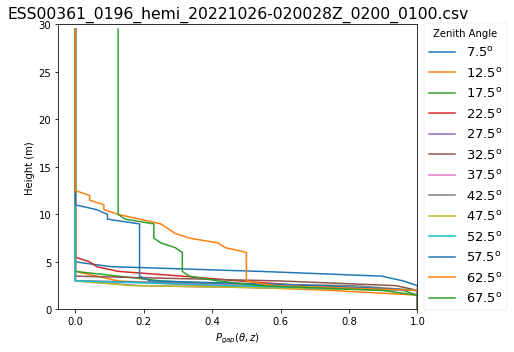

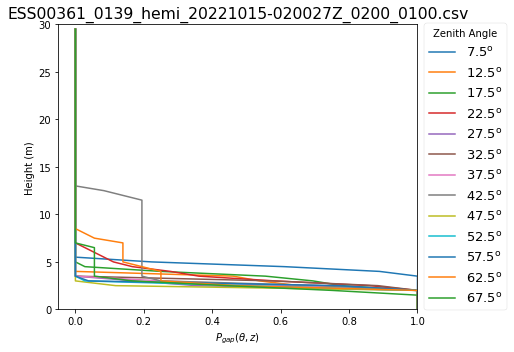

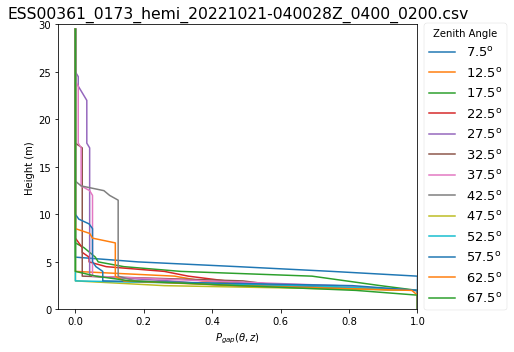

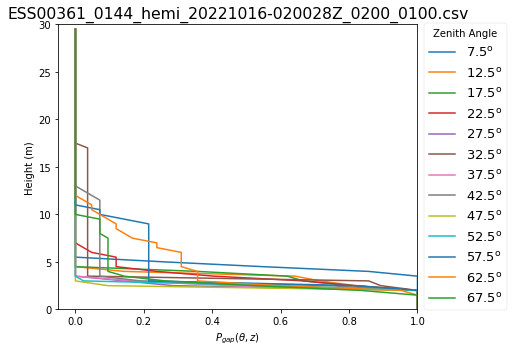

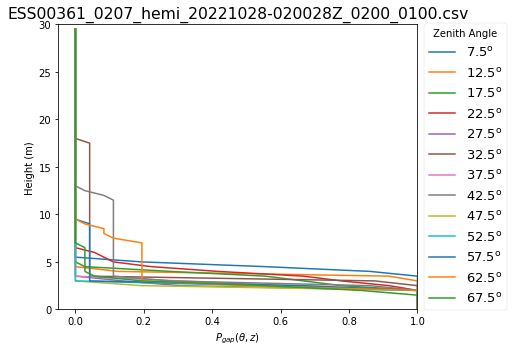

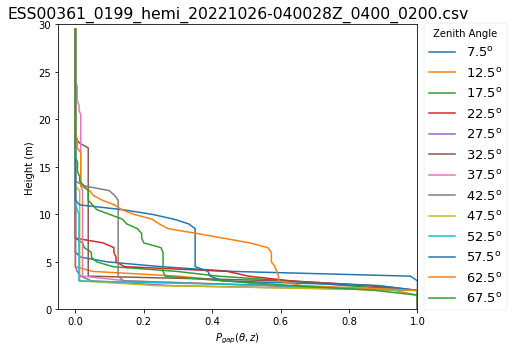

In [23]:
for leaf_file in data_csv_list:
    vpp = plant_profile.Jupp2009(hres=0.5, zres=5, ares=90, min_z=5, max_z=70, min_h=0, max_h=30)
    valid = vpp.add_leaf_scan_position(leaf_file, method='WEIGHTED', min_zenith=5, max_zenith=70, sensor_height=1.5)
    if valid:
        vpp.get_pgap_theta_z()
        title = os.path.basename(leaf_file)
        pgap_labels = [fr'{b:.1f}$\rm ^o$' for b in vpp.zenith_bin]
        plot_vertical_profiles(vpp.pgap_theta_z, vpp.height_bin, xlabel=r'$P_{gap}(\theta,z)$',
                               labels=pgap_labels, ylim=[0,30], xlim=[None,1], figsize=[7,5], title=title)